<a href="https://colab.research.google.com/github/UmbrellaMalware/PythonAnalysisCourse/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Данные

Для выполнения работы возьмите данные, которые рассматривались в колабе в примерами.

In [65]:
%%capture
!wget https://www.dropbox.com/s/7txlgjt9spcx9sp/covid_vaccine_statewise.csv
!wget https://www.dropbox.com/s/pdjots49xlb2d9h/StatewiseTestingDetails.csv
!wget https://www.dropbox.com/s/mpv865w1l7kces9/covid_19_india.csv

# Задание 1

Обработайте столбцы и строки с пустами ячейками в таблице `covid_vaccine_statewise`: определите, какие стоит удалить, какие стоит заполнить и каким образом.

Для ячеек, которые нужно заполнить, рассмотрите два подхода:
1. статистический (масимальными, средними, наиболее частотными значениями)
2. путем предсказания (регрессией или классификацией)

In [66]:
import pandas as pd
import missingno as msno

In [67]:
cvs = pd.read_csv('covid_vaccine_statewise.csv')

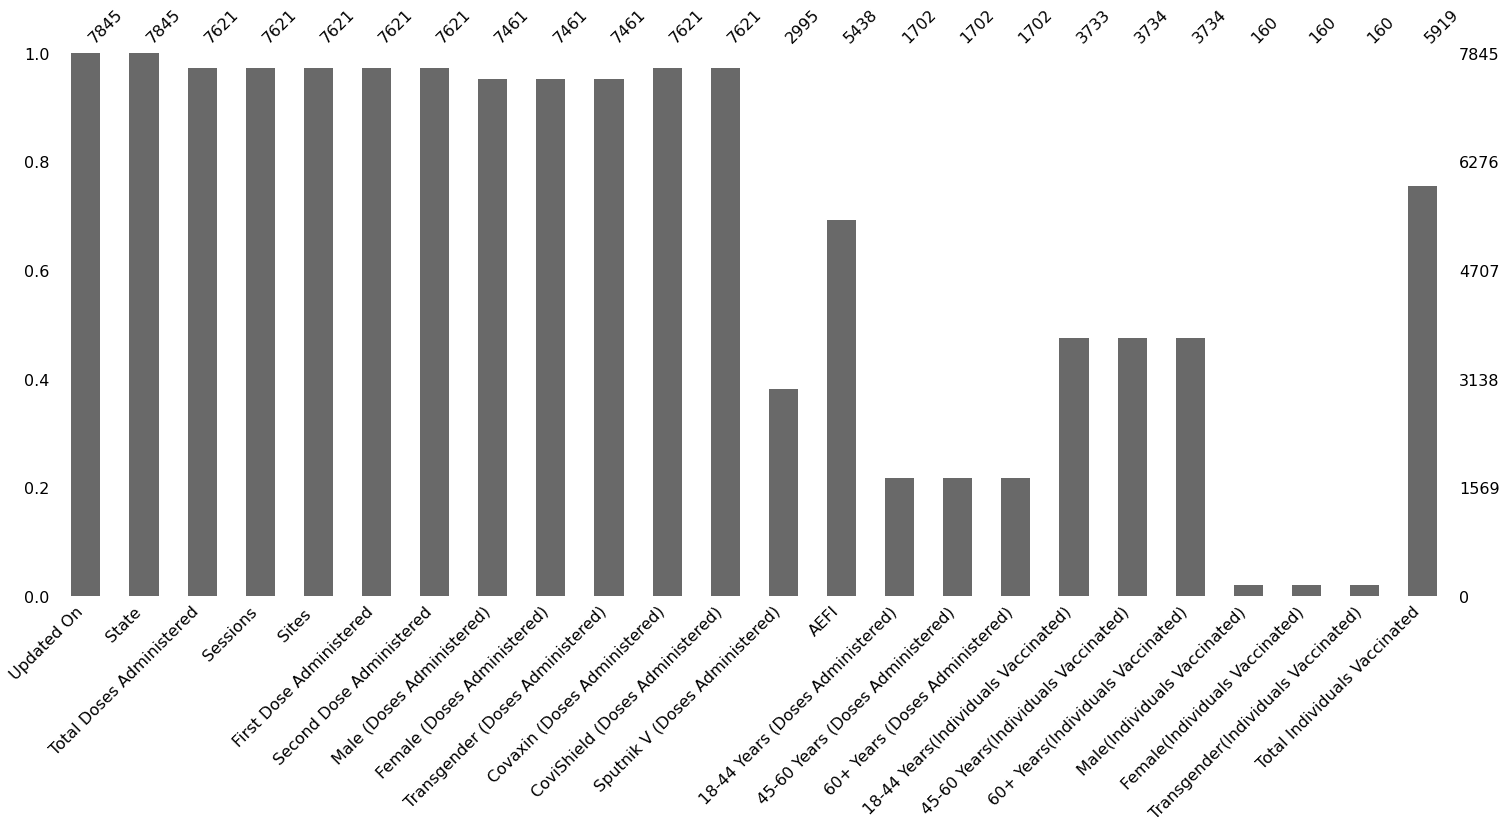

In [68]:
msno.bar(cvs);

Предлагаю удалить колонки, заполненность которых <60%

In [69]:
delete_list = []
for i in cvs:
  data_percent = cvs[i].count()/len(cvs[i])*100
  if data_percent < 60:
    delete_list.append(i)
print(f'this column will be deleted {delete_list}')
cvs = cvs.drop(delete_list, axis=1)

this column will be deleted ['Sputnik V (Doses Administered)', '18-44 Years (Doses Administered)', '45-60 Years (Doses Administered)', '60+ Years (Doses Administered)', '18-44 Years(Individuals Vaccinated)', '45-60 Years(Individuals Vaccinated)', '60+ Years(Individuals Vaccinated)', 'Male(Individuals Vaccinated)', 'Female(Individuals Vaccinated)', 'Transgender(Individuals Vaccinated)']


In [70]:
cvs["Total Individuals Vaccinated"].fillna(cvs["First Dose Administered"], inplace=True)

In [71]:
cvs.head(10)

,Updated On,State,Total Doses Administered,Sessions,Sites,First Dose Administered,Second Dose Administered,Male (Doses Administered),Female (Doses Administered),Transgender (Doses Administered),Covaxin (Doses Administered),CoviShield (Doses Administered),AEFI,Total Individuals Vaccinated
0,16/01/2021,India,48276.0,3455.0,2957.0,48276.0,0.0,NaN,NaN,NaN,579.0,47697.0,NaN,48276.0
1,17/01/2021,India,58604.0,8532.0,4954.0,58604.0,0.0,NaN,NaN,NaN,635.0,57969.0,NaN,58604.0
2,18/01/2021,India,99449.0,13611.0,6583.0,99449.0,0.0,NaN,NaN,NaN,1299.0,98150.0,NaN,99449.0
3,19/01/2021,India,195525.0,17855.0,7951.0,195525.0,0.0,NaN,NaN,NaN,3017.0,192508.0,NaN,195525.0
4,20/01/2021,India,251280.0,25472.0,10504.0,251280.0,0.0,NaN,NaN,NaN,3946.0,247334.0,NaN,251280.0
5,21/01/2021,India,365965.0,32226.0,12600.0,365965.0,0.0,NaN,NaN,NaN,5367.0,360598.0,NaN,365965.0
6,22/01/2021,India,549381.0,36988.0,14115.0,549381.0,0.0,NaN,NaN,NaN,8128.0,541253.0,NaN,549381.0
7,23/01/2021,India,759008.0,43076.0,15605.0,759008.0,0.0,NaN,NaN,NaN,11192.0,747816.0,NaN,759008.0
8,24/01/2021,India,835058.0,49851.0,18111.0,835058.0,0.0,NaN,NaN,NaN,13156.0,821902.0,NaN,835058.0
9,25/01/2021,India,1277104.0,55151.0,19682.0,1277104.0,0.0,NaN,NaN,NaN,18858.0,1258246.0,NaN,1277104.0


In [72]:
from copy import deepcopy

cp_cvs = deepcopy(cvs)

In [73]:
cp_cvs.head(10)

,Updated On,State,Total Doses Administered,Sessions,Sites,First Dose Administered,Second Dose Administered,Male (Doses Administered),Female (Doses Administered),Transgender (Doses Administered),Covaxin (Doses Administered),CoviShield (Doses Administered),AEFI,Total Individuals Vaccinated
0,16/01/2021,India,48276.0,3455.0,2957.0,48276.0,0.0,NaN,NaN,NaN,579.0,47697.0,NaN,48276.0
1,17/01/2021,India,58604.0,8532.0,4954.0,58604.0,0.0,NaN,NaN,NaN,635.0,57969.0,NaN,58604.0
2,18/01/2021,India,99449.0,13611.0,6583.0,99449.0,0.0,NaN,NaN,NaN,1299.0,98150.0,NaN,99449.0
3,19/01/2021,India,195525.0,17855.0,7951.0,195525.0,0.0,NaN,NaN,NaN,3017.0,192508.0,NaN,195525.0
4,20/01/2021,India,251280.0,25472.0,10504.0,251280.0,0.0,NaN,NaN,NaN,3946.0,247334.0,NaN,251280.0
5,21/01/2021,India,365965.0,32226.0,12600.0,365965.0,0.0,NaN,NaN,NaN,5367.0,360598.0,NaN,365965.0
6,22/01/2021,India,549381.0,36988.0,14115.0,549381.0,0.0,NaN,NaN,NaN,8128.0,541253.0,NaN,549381.0
7,23/01/2021,India,759008.0,43076.0,15605.0,759008.0,0.0,NaN,NaN,NaN,11192.0,747816.0,NaN,759008.0
8,24/01/2021,India,835058.0,49851.0,18111.0,835058.0,0.0,NaN,NaN,NaN,13156.0,821902.0,NaN,835058.0
9,25/01/2021,India,1277104.0,55151.0,19682.0,1277104.0,0.0,NaN,NaN,NaN,18858.0,1258246.0,NaN,1277104.0


In [74]:
split_idxs = [0]
current_state = cp_cvs["State"][0]
for idx, state in cp_cvs["State"].iteritems():
  if state != current_state:
    split_idxs.append(idx + 1)
    current_state = state
split_idxs.append(len(cp_cvs["State"]))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


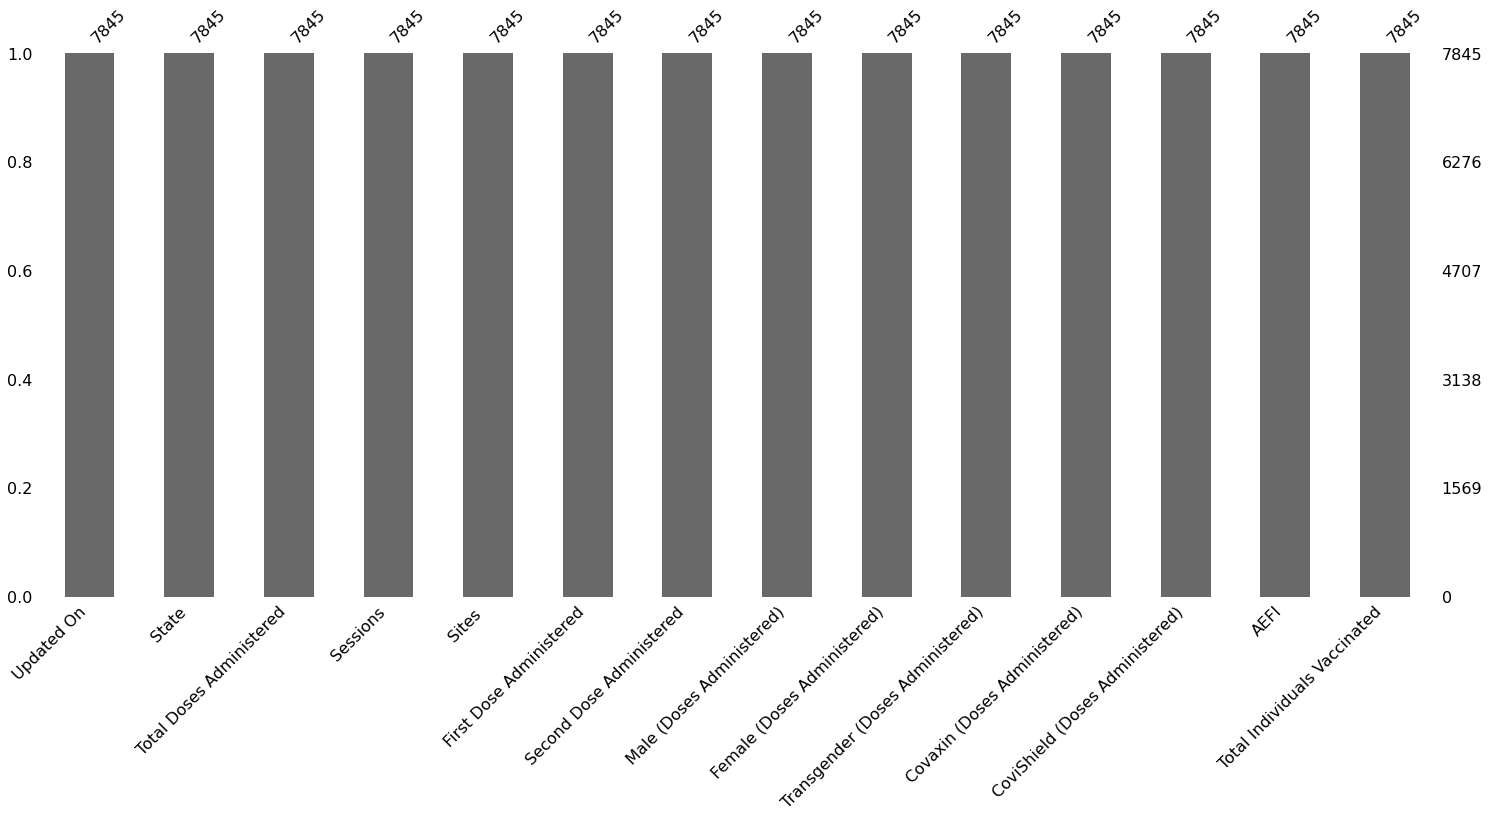

In [75]:
partitions = []
for idx in range(0, len(split_idxs) - 1):
  prev = split_idxs[idx]
  next = split_idxs[idx + 1]
  cp_cvs[prev:prev+1].fillna(0, inplace=True)
  partitions.append(cp_cvs[prev:next].interpolate(method='linear', limit_direction='forward'))

cp_cvs = pd.concat(partitions)
msno.bar(cp_cvs);

In [76]:
import time
dataset_for_regression = deepcopy(cvs)
dataset_for_regression["Updated On"] = pd.to_datetime(dataset_for_regression["Updated On"]).apply(lambda x: time.mktime(x.timetuple()))
state_columns = pd.get_dummies(dataset_for_regression["State"])
dataset_for_regression = dataset_for_regression.join(state_columns)
dataset_for_regression = dataset_for_regression.drop(columns=["Total Individuals Vaccinated", "State"])

In [77]:
dataset_for_regression.head()

,Updated On,Total Doses Administered,Sessions,Sites,First Dose Administered,Second Dose Administered,Male (Doses Administered),Female (Doses Administered),Transgender (Doses Administered),Covaxin (Doses Administered),CoviShield (Doses Administered),AEFI,Andaman and Nicobar Islands,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chandigarh,Chhattisgarh,Dadra and Nagar Haveli and Daman and Diu,Delhi,Goa,Gujarat,Haryana,Himachal Pradesh,India,Jammu and Kashmir,Jharkhand,Karnataka,Kerala,Ladakh,Lakshadweep,Madhya Pradesh,Maharashtra,Manipur,Meghalaya,Mizoram,Nagaland,Odisha,Puducherry,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,Uttar Pradesh,Uttarakhand,West Bengal
0,1.610755e+09,48276.0,3455.0,2957.0,48276.0,0.0,NaN,NaN,NaN,579.0,47697.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.610842e+09,58604.0,8532.0,4954.0,58604.0,0.0,NaN,NaN,NaN,635.0,57969.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.610928e+09,99449.0,13611.0,6583.0,99449.0,0.0,NaN,NaN,NaN,1299.0,98150.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.611014e+09,195525.0,17855.0,7951.0,195525.0,0.0,NaN,NaN,NaN,3017.0,192508.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.611101e+09,251280.0,25472.0,10504.0,251280.0,0.0,NaN,NaN,NaN,3946.0,247334.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
dataset_no_nans = deepcopy(dataset_for_regression[dataset_for_regression.notna().all(1)])
dataset_to_fill = deepcopy(dataset_for_regression[dataset_for_regression.iloc[:, :11].notna().all(1)])
dataset_to_fill = dataset_to_fill[dataset_to_fill["AEFI"].isna()]

targets = dataset_no_nans["AEFI"]
dataset_no_nans.drop(columns=["AEFI"], axis=0, inplace=True)

In [79]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [80]:
normalized_df=(dataset_no_nans-dataset_no_nans.min())/(dataset_no_nans.max()-dataset_no_nans.min())

In [81]:
X_train, X_test, y_train, y_test = train_test_split(normalized_df, targets, test_size=0.25, random_state=42)

In [82]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print("Coefficients: \n", regr.coef_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [ 2.35786089e+01  4.57500658e+03 -1.42075787e+03  1.19714757e+03
  4.54402943e+03  4.68462610e+03  2.69573758e+04 -2.85540702e+04
 -1.08050121e+04  1.08466165e+03  8.68672497e+03 -8.04980664e+02
 -6.72420379e+02 -5.42672900e+02 -7.67849879e+02 -9.08723112e+02
 -7.01318542e+02 -4.16687102e+02 -7.18907427e+02 -9.56618538e+01
 -2.64472776e+02 -4.26746674e+02 -1.36031556e+02 -1.92665058e+02
  1.43606882e+04 -8.19149931e+02 -3.32462934e+02  1.37226999e+03
  1.36236986e+03 -8.05777270e+02 -8.03025614e+02 -6.30082384e+02
  2.20895478e+03 -7.32287141e+02 -5.57784150e+02 -7.95318965e+01
 -7.78091906e+02 -7.85804530e+02 -7.89903103e+02 -8.57284279e+02
 -8.27281960e+02 -5.73199650e+02 -9.85705271e+02 -5.86482416e+02
 -7.94341861e+02 -1.41571275e+02 -5.63151951e+02 -2.12225382e+02]
Mean squared error: 11367.86
Coefficient of determination: 1.00


In [83]:
dataset_to_fill.drop(columns=["AEFI"], inplace=True)

In [84]:
normalized_df=(dataset_to_fill-dataset_to_fill.min())/(dataset_to_fill.max()-dataset_to_fill.min())

In [85]:
normalized_df.fillna(0, inplace=True)

In [86]:
pred = regr.predict(normalized_df)

In [87]:
dataset_to_fill["AEFI"] = pred
dataset_to_fill.loc[dataset_to_fill['AEFI'] < 0, 'AEFI'] = 0

In [88]:
dataset_to_fill

,Updated On,Total Doses Administered,Sessions,Sites,First Dose Administered,Second Dose Administered,Male (Doses Administered),Female (Doses Administered),Transgender (Doses Administered),Covaxin (Doses Administered),CoviShield (Doses Administered),Andaman and Nicobar Islands,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chandigarh,Chhattisgarh,Dadra and Nagar Haveli and Daman and Diu,Delhi,Goa,Gujarat,Haryana,Himachal Pradesh,India,Jammu and Kashmir,Jharkhand,Karnataka,Kerala,Ladakh,Lakshadweep,Madhya Pradesh,Maharashtra,Manipur,Meghalaya,Mizoram,Nagaland,Odisha,Puducherry,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,Uttar Pradesh,Uttarakhand,West Bengal,AEFI
212,1.610755e+09,23.0,2.0,2.0,23.0,0.0,12.0,11.0,0.0,0.0,23.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
213,1.610842e+09,23.0,2.0,2.0,23.0,0.0,12.0,11.0,0.0,0.0,23.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
214,1.610928e+09,42.0,9.0,2.0,42.0,0.0,29.0,13.0,0.0,0.0,42.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
215,1.611014e+09,89.0,12.0,2.0,89.0,0.0,53.0,36.0,0.0,0.0,89.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
216,1.611101e+09,124.0,16.0,3.0,124.0,0.0,67.0,57.0,0.0,0.0,124.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7687,1.635898e+09,1801974.0,361008.0,1794.0,1486241.0,315733.0,1093842.0,707926.0,206.0,191682.0,1610193.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10119.983748
7688,1.638490e+09,1983003.0,612398.0,2987.0,1641083.0,341920.0,1195941.0,786842.0,220.0,201849.0,1781055.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10659.631719
7689,1.615594e+09,2104249.0,464570.0,2386.0,1742140.0,362109.0,1262535.0,841476.0,238.0,208534.0,1895615.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,11082.587658
7690,1.615680e+09,2117985.0,180750.0,794.0,1753914.0,364071.0,1270369.0,847377.0,239.0,209422.0,1908463.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,11514.522220


# Задание 2

По таблице `covid_19_india` определите, есть ли закономерности во времени обновления данных.

In [89]:
covid19_india = pd.read_csv('covid_19_india.csv')

In [90]:
covid19_india.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


In [91]:
covid19_india.min()

Sno                                                   1
Date                                         2020-01-30
Time                                           10:00 AM
State/UnionTerritory        Andaman and Nicobar Islands
ConfirmedIndianNational                               -
ConfirmedForeignNational                              -
Cured                                                 0
Deaths                                                0
Confirmed                                             0
dtype: object

In [92]:
covid19_india.max()

Sno                               18110
Date                         2021-08-11
Time                            9:30 PM
State/UnionTerritory        West Bengal
ConfirmedIndianNational               9
ConfirmedForeignNational              9
Cured                           6159676
Deaths                           134201
Confirmed                       6363442
dtype: object

In [93]:
df = covid19_india.groupby(["Date"])["State/UnionTerritory"].count()

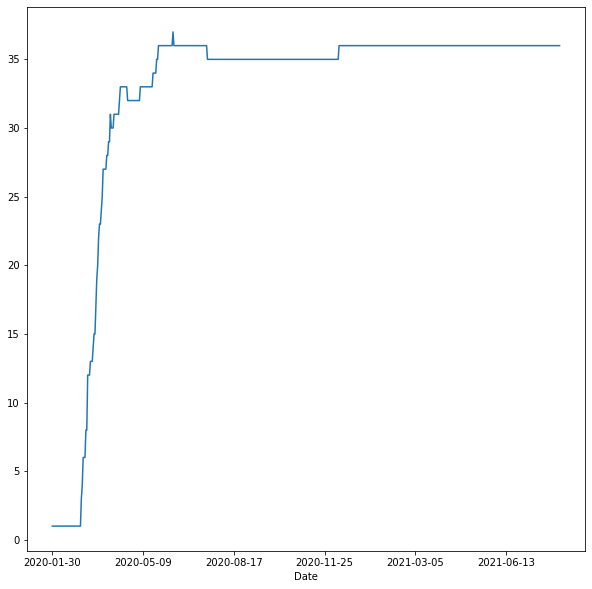

In [94]:
df.plot(figsize=(10,10))

Видно, что с течением времени все больше и больше регионов обновляли данные

In [95]:
df = covid19_india.groupby(["Date"])["Time"].agg(pd.Series.mode)

In [96]:
df

Date
2020-01-30    6:00 PM
2020-01-31    6:00 PM
2020-02-01    6:00 PM
2020-02-02    6:00 PM
2020-02-03    6:00 PM
               ...   
2021-08-07    8:00 AM
2021-08-08    8:00 AM
2021-08-09    8:00 AM
2021-08-10    8:00 AM
2021-08-11    8:00 AM
Name: Time, Length: 560, dtype: object

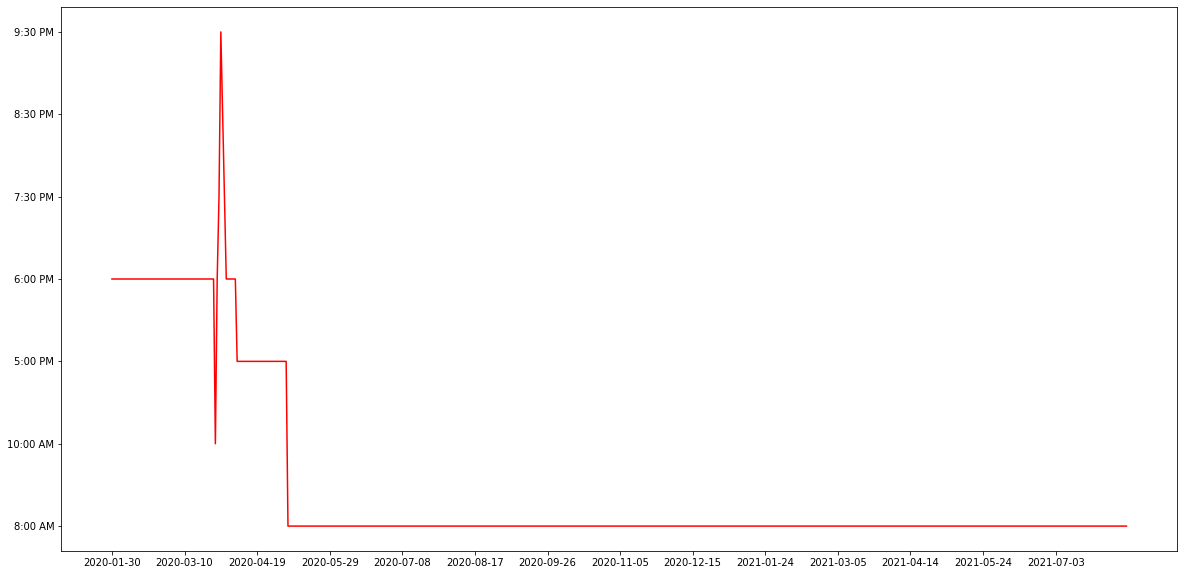

In [97]:
from matplotlib import pyplot as plt
import numpy as np

times = np.array(['8:00 AM', '10:00 AM', '5:00 PM', '6:00 PM', '7:30 PM', '8:30 PM','9:30 PM'])

x = np.array(df.index)

y = [np.where(times == value)[0][0] for value in df.values]

plt.figure(figsize=(20,10))
plt.xticks(ticks=list(range(0, len(x), 40)), labels=x[::40])
plt.yticks(ticks=list(range(0, len(times)+ 1)), labels=times)

plt.plot(x, y, 'r')

Видно, что спустя некоторый хаотичный период, данные стали обновлять в 8 утра

# Задание 3

По таблицам `covid_19_india`, `covid_vaccine_statewise` определите, есть ли взаимосвязь между типом вакцины, количеством умерших, количеством вакцинировавшихся и регионом Индии. Рассмотрите зависимости факторов как попарно, так и в совокупности.

**Опционально:** визуализируйте результат.

In [98]:
import numpy as np

In [99]:
def change_gormat(s):
  split = s.split('/')
  return split[2] + '-' + split[1] + '-' + split[0]

In [100]:
cvs = deepcopy(cp_cvs)
cvs["Updated On"] = cvs["Updated On"].apply(lambda x: change_gormat(x))

In [101]:
cvs.head()

,Updated On,State,Total Doses Administered,Sessions,Sites,First Dose Administered,Second Dose Administered,Male (Doses Administered),Female (Doses Administered),Transgender (Doses Administered),Covaxin (Doses Administered),CoviShield (Doses Administered),AEFI,Total Individuals Vaccinated
0,2021-01-16,India,48276.0,3455.0,2957.0,48276.0,0.0,0.000000e+00,0.000000e+00,0.000,579.0,47697.0,0.000000,48276.0
1,2021-01-17,India,58604.0,8532.0,4954.0,58604.0,0.0,1.043730e+06,8.922135e+05,321.975,635.0,57969.0,243.745763,58604.0
2,2021-01-18,India,99449.0,13611.0,6583.0,99449.0,0.0,2.087460e+06,1.784427e+06,643.950,1299.0,98150.0,487.491525,99449.0
3,2021-01-19,India,195525.0,17855.0,7951.0,195525.0,0.0,3.131191e+06,2.676641e+06,965.925,3017.0,192508.0,731.237288,195525.0
4,2021-01-20,India,251280.0,25472.0,10504.0,251280.0,0.0,4.174921e+06,3.568854e+06,1287.900,3946.0,247334.0,974.983051,251280.0


In [102]:
covid19_india = pd.read_csv('covid_19_india.csv')

In [103]:
# Найдём даты по которым мы будем строить графики
from collections import Counter

intersected_dates = np.intersect1d(covid19_india['Date'].unique(), cvs["Updated On"].unique())
intersected_states = np.intersect1d(covid19_india['State/UnionTerritory'].unique(), cvs['State'].unique())

In [105]:
zeros = np.zeros(len(intersected_states))
death_by_date = []
vac_by_date = []
covaxin_by_date = []
covishield_by_date = []
death_by_state = dict(zip(intersected_states, zeros))
vac_by_state = dict(zip(intersected_states, zeros))
covaxin_by_state = dict(zip(intersected_states, zeros))
covishield_by_state = dict(zip(intersected_states, zeros))
for state in intersected_states:
  cvs_value = cvs.loc[cvs['State'] == state]
  vac_by_state[state] = max(cvs_value['Total Doses Administered'].values)
  covaxin_by_state[state] = max(cvs_value[' Covaxin (Doses Administered)'].values)
  covishield_by_state[state] = max(cvs_value['CoviShield (Doses Administered)'].values)

In [106]:
for date in intersected_dates:
  death = 0
  vac = 0
  vac_covaxin = 0
  vac_covishield = 0
  for state in intersected_states:
    covid_df_value = covid19_india.loc[(covid19_india['Date'] == date) & (covid19_india['State/UnionTerritory'] == state)]
    death_value = covid_df_value['Deaths']
    if not death_value.empty:
      death += death_value.values[0]
      death_by_state[state] += death_value.values[0]

    cvs_value = cvs.loc[(cvs['Updated On'] == date) & (cvs['State'] == state)]
    
    if not cvs_value['Total Doses Administered'].empty:
      vac += cvs_value['Total Doses Administered'].values[0]
    if not cvs_value[' Covaxin (Doses Administered)'].empty:
      vac_covaxin += cvs_value[' Covaxin (Doses Administered)'].values[0]

    if not cvs_value['CoviShield (Doses Administered)'].empty:
      vac_covishield += cvs_value['CoviShield (Doses Administered)'].values[0]

  death_by_date.append(death)
  vac_by_date.append(vac)
  covaxin_by_date.append(vac_covaxin)
  covishield_by_date.append(vac_covishield)

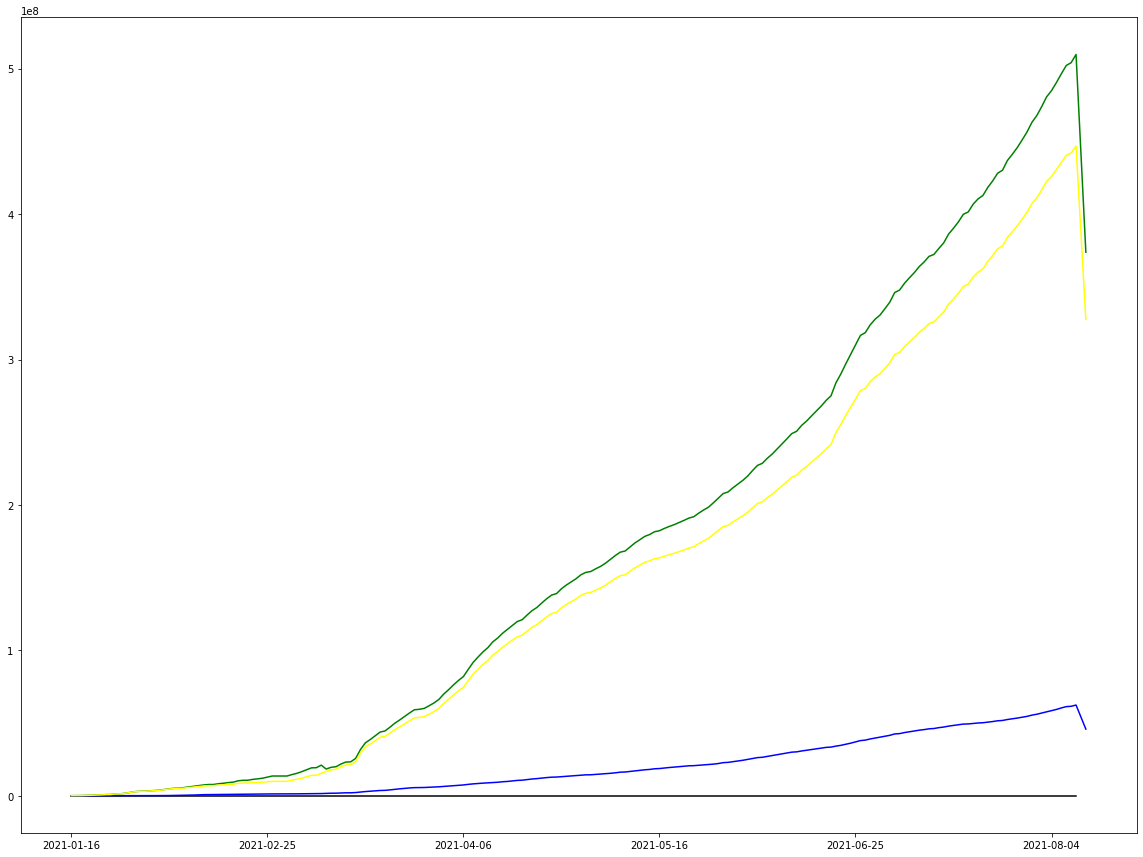

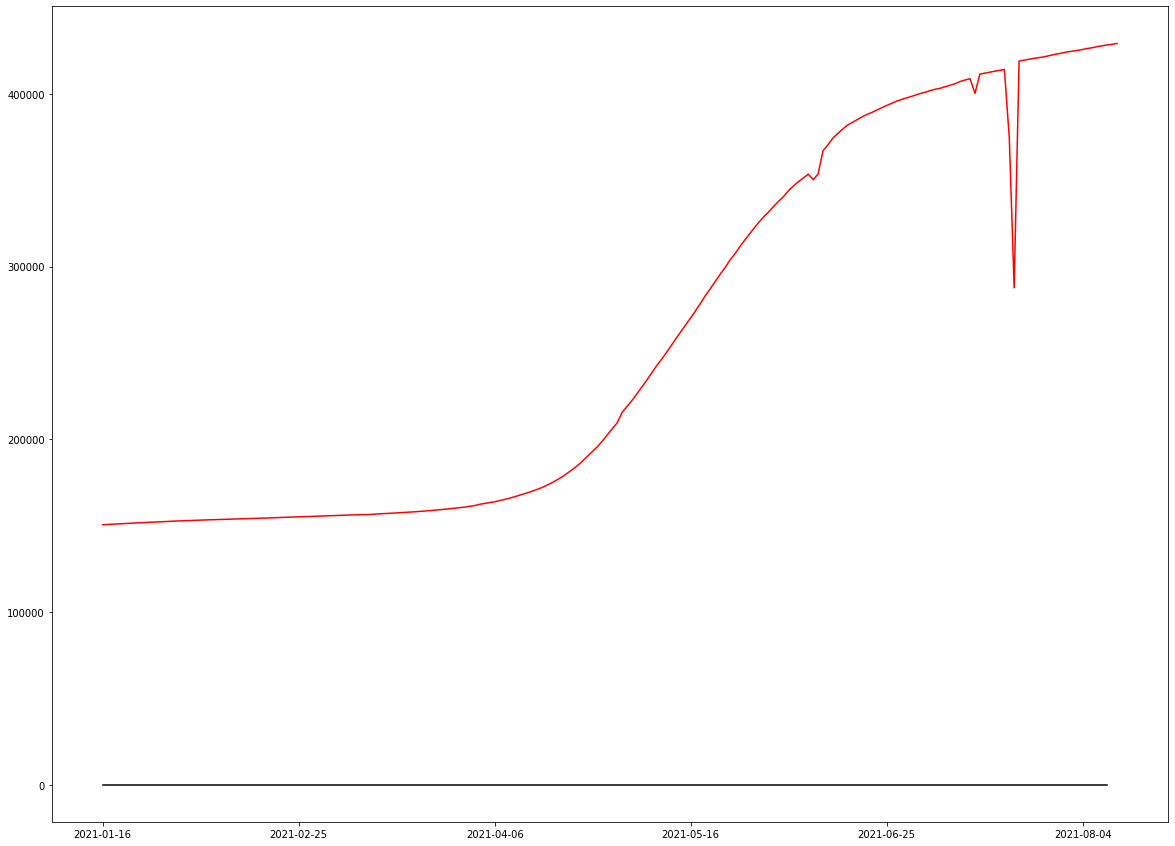

In [107]:
import matplotlib.pyplot as plt

x = np.zeros(206)
plt.figure(figsize=(20, 15))
plt.xticks(ticks=list(range(0, len(intersected_dates), 40)), labels=intersected_dates[::40])
plt.plot(x, color='black')
plt.plot(intersected_dates, vac_by_date, color='green')
plt.plot(intersected_dates, covaxin_by_date, color='blue')
plt.plot(intersected_dates, covishield_by_date, color='yellow')

plt.show()

x = np.zeros(206)
plt.figure(figsize=(20, 15))
plt.xticks(ticks=list(range(0, len(intersected_dates), 40)), labels=intersected_dates[::40])
plt.plot(x, color='black')
plt.plot(intersected_dates, death_by_date, color='red')
plt.show()

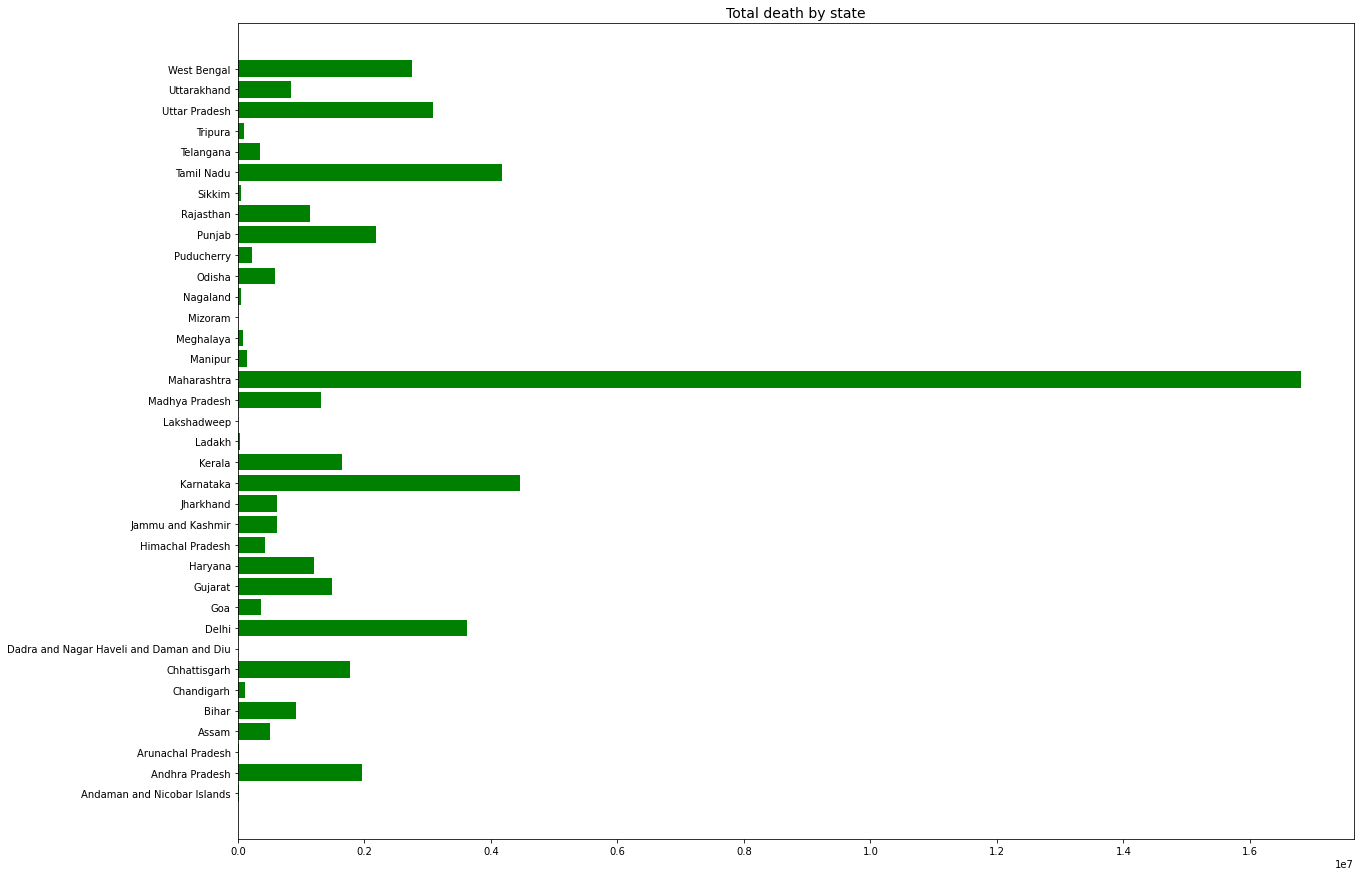

In [110]:
index = np.arange(len(intersected_states))

plt.figure(figsize=(20, 15))
plt.title('Total death by state', fontsize=14)
plt.barh(index, death_by_state.values(), color='green')
plt.yticks(index, intersected_states)
plt.show()

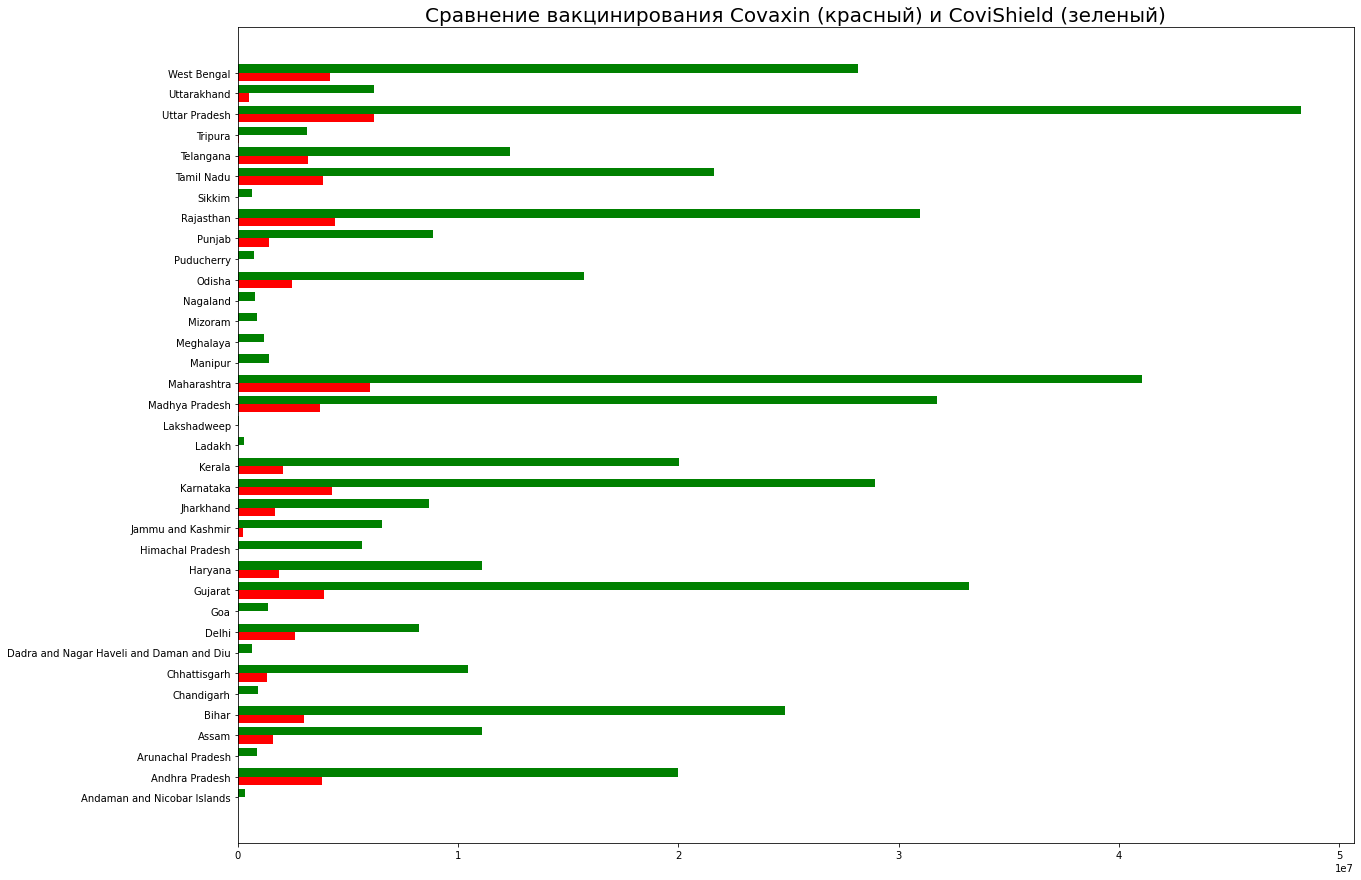

In [112]:
width = 0.4
plt.figure(figsize=(20, 15))
plt.title('Сравнение вакцинирования Covaxin (красный) и CoviShield (зеленый)', fontsize=20)
plt.barh(index, covaxin_by_state.values(), width, color='red')
plt.barh(index+width, covishield_by_state.values(), width, color='green')
plt.yticks(index+width/2, intersected_states)

plt.show()

Много смертей в густонаселенных штатах. Ковишилдом вакцинировано больше людей чем Коваксином

# Задание 4

По всем трем таблицам определите, как с каждым месяцем от начала наблюдений менялось количество умерших, вакцинированных и тех, кто имеет положительный тест. Наблюдается ли этих в данных закономерность?

**Опционально:** визуализируйте результат.

Графики количества умерших и вакицинированных были построены в задании 3. Продублирую вывод и тут. Рост графика смертей к концу замедлился (значит новых смертей все меньше и меньше). Рост общего количества вакцинированного населения продолжал расти (темпы вакцинации примерно стабильные)

In [113]:
def calc_pos(x):
  if (not x["Positive"]):
    print(float(x["TotalSamples"]) - float(x["Negative"]))
    return float(x["TotalSamples"]) - float(x["Negative"])
  return x["Positive"]

In [115]:
std = pd.read_csv("StatewiseTestingDetails.csv")
std = std.loc[(std["Positive"].notna()) | (std["Negative"].notna())]
std["Negative"] = pd.to_numeric(std['Negative'], errors='coerce')
std.loc[std['Positive'].isna(), 'Positive'] = std["TotalSamples"] - std["Negative"]

In [116]:
std.head(10)

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210.0,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0
5,2020-05-19,Andaman and Nicobar Islands,6965.0,NaN,33.0
6,2020-05-20,Andaman and Nicobar Islands,7082.0,NaN,33.0
7,2020-05-21,Andaman and Nicobar Islands,7167.0,NaN,33.0
8,2020-05-22,Andaman and Nicobar Islands,7263.0,NaN,33.0
9,2020-05-23,Andaman and Nicobar Islands,7327.0,NaN,33.0


In [117]:
std[std["Positive"].isna()]

,Date,State,TotalSamples,Negative,Positive


In [119]:
std = std.loc[(std["Positive"] > 0) & (std["Positive"] < 20000000)]

In [120]:
testsByDate = std.groupby("Date")["Positive"].sum()

In [121]:
dates = np.array(testsByDate.index)

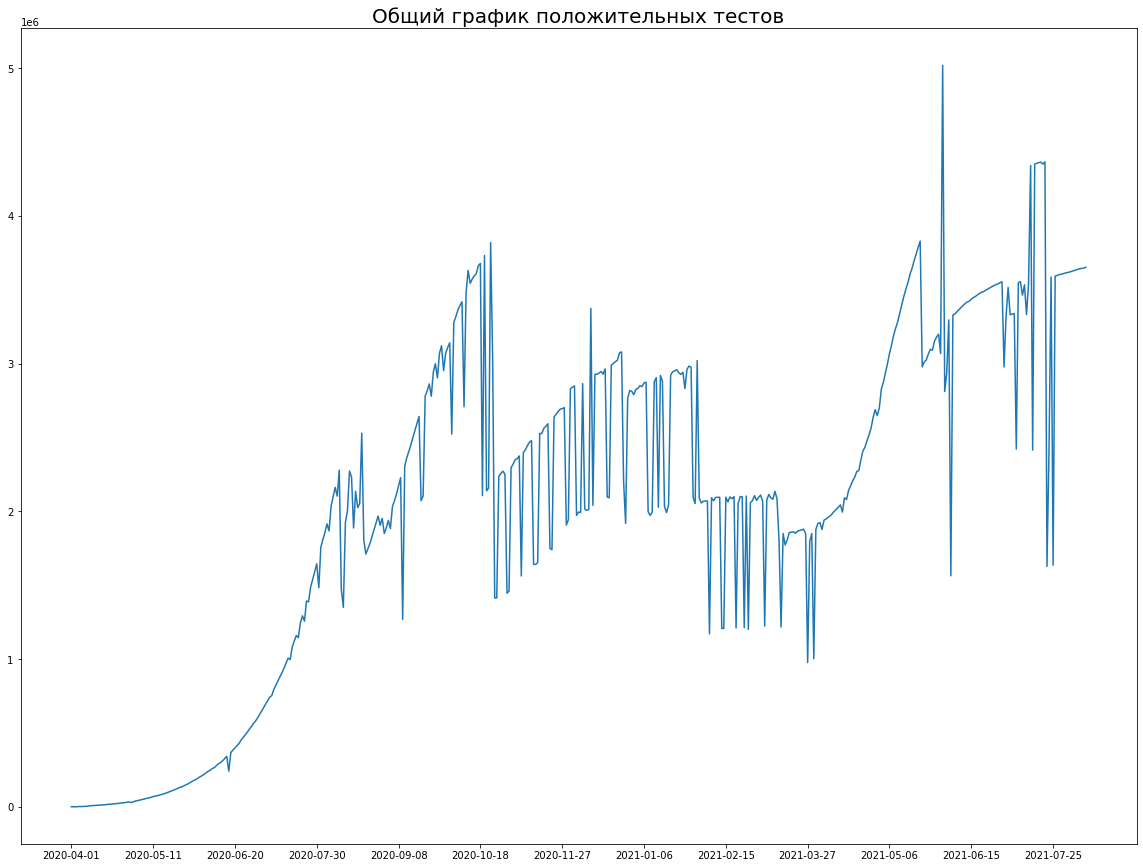

In [122]:
plt.figure(figsize=(20, 15))
plt.xticks(ticks=list(range(0, len(dates), 40)), labels=dates[::40])
plt.title('Общий график положительных тестов', fontsize=20)
plt.plot(testsByDate.values)
plt.show()

На графике видно, что количество положительных тестов в конце наблюдаемого периода почти не увеличивается. Вероятно, это связано с большим количеством вакцинированного населения

# Задание 5

Сформулируйте и проверьте одну гипотезу по данным самостоятельно.

Возьмем 2 самых крупных штата Индии по населению. Попытаться объяснить почему в Махараштра смертей больше чем Уттар-Прадеш, при том что в штате Махараштра население меньше почти на 80млн

In [123]:
import pandas as pd

In [126]:
cvs = pd.read_csv('covid_vaccine_statewise.csv')
covid_19_india = pd.read_csv('covid_19_india.csv')

In [128]:
cvs = cvs.loc[(cvs["State"] == "Uttar Pradesh") | (cvs["State"] == "Maharashtra")]

In [127]:
cvs.head()

,Updated On,State,Total Doses Administered,Sessions,Sites,First Dose Administered,Second Dose Administered,Male (Doses Administered),Female (Doses Administered),Transgender (Doses Administered),Covaxin (Doses Administered),CoviShield (Doses Administered),Sputnik V (Doses Administered),AEFI,18-44 Years (Doses Administered),45-60 Years (Doses Administered),60+ Years (Doses Administered),18-44 Years(Individuals Vaccinated),45-60 Years(Individuals Vaccinated),60+ Years(Individuals Vaccinated),Male(Individuals Vaccinated),Female(Individuals Vaccinated),Transgender(Individuals Vaccinated),Total Individuals Vaccinated
0,16/01/2021,India,48276.0,3455.0,2957.0,48276.0,0.0,NaN,NaN,NaN,579.0,47697.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23757.0,24517.0,2.0,48276.0
1,17/01/2021,India,58604.0,8532.0,4954.0,58604.0,0.0,NaN,NaN,NaN,635.0,57969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27348.0,31252.0,4.0,58604.0
2,18/01/2021,India,99449.0,13611.0,6583.0,99449.0,0.0,NaN,NaN,NaN,1299.0,98150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41361.0,58083.0,5.0,99449.0
3,19/01/2021,India,195525.0,17855.0,7951.0,195525.0,0.0,NaN,NaN,NaN,3017.0,192508.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81901.0,113613.0,11.0,195525.0
4,20/01/2021,India,251280.0,25472.0,10504.0,251280.0,0.0,NaN,NaN,NaN,3946.0,247334.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98111.0,153145.0,24.0,251280.0


In [129]:
cvs.groupby("State")["Total Individuals Vaccinated"].max()

State
Maharashtra      24046509.0
Uttar Pradesh    24782239.0
Name: Total Individuals Vaccinated, dtype: float64

В штате Uttar Pradesh вакцинировано на 700000 больше

Сравним вид вакцины

In [130]:
cvs.groupby("State")[" Covaxin (Doses Administered)", "CoviShield (Doses Administered)"].max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Covaxin (Doses Administered),CoviShield (Doses Administered)
State,,
Maharashtra,6005390.0,41051969.0
Uttar Pradesh,6171089.0,48258007.0


In [131]:
#Данные по населению из википедии

uttar_population = 199581477
mah_population = 112372972

print(f"Percent of Covaxin vaccinated in Maharashtra {6005390.0 / mah_population * 100}%")
print(f"Percent of CoviShield vaccinated in Maharashtra {41051969.0 / mah_population * 100}%")

print(f"Percent of Covaxin vaccinated in Uttar Pradesh	 {6171089.0 / uttar_population * 100}%")
print(f"Percent of CoviShield vaccinated in Uttar Pradesh	 {48258007.0 / uttar_population * 100}%")

Percent of Covaxin vaccinated in Maharashtra 5.344158735963663%
Percent of CoviShield vaccinated in Maharashtra 36.53188864667564%
Percent of Covaxin vaccinated in Uttar Pradesh	 3.0920148967531693%
Percent of CoviShield vaccinated in Uttar Pradesh	 24.179602098044402%


Процент вакцинированного населения в Maharashtra больше

In [132]:
covid_19_india.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


In [133]:
covid_19_india = covid_19_india.loc[(covid_19_india["State/UnionTerritory"] == "Uttar Pradesh") | (covid_19_india["State/UnionTerritory"] == "Maharashtra")]

In [134]:
covid_19_india.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
39,40,2020-03-04,6:00 PM,Uttar Pradesh,6,0,0,0,6
50,51,2020-03-05,6:00 PM,Uttar Pradesh,7,0,0,0,7
55,56,2020-03-06,6:00 PM,Uttar Pradesh,7,0,0,0,7
58,59,2020-03-07,6:00 PM,Uttar Pradesh,7,0,0,0,7
72,73,2020-03-08,6:00 PM,Uttar Pradesh,7,0,0,0,7


In [135]:
import numpy as np

In [136]:
covid_19_india = covid_19_india.replace('-', np.NaN)


In [137]:
covid_19_india[covid_19_india["ConfirmedIndianNational"].notna()]

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
39,40,2020-03-04,6:00 PM,Uttar Pradesh,6,0,0,0,6
50,51,2020-03-05,6:00 PM,Uttar Pradesh,7,0,0,0,7
55,56,2020-03-06,6:00 PM,Uttar Pradesh,7,0,0,0,7
58,59,2020-03-07,6:00 PM,Uttar Pradesh,7,0,0,0,7
72,73,2020-03-08,6:00 PM,Uttar Pradesh,7,0,0,0,7
76,77,2020-03-09,6:00 PM,Maharashtra,2,0,0,0,2
82,83,2020-03-09,6:00 PM,Uttar Pradesh,7,0,0,0,7
85,86,2020-03-10,6:00 PM,Uttar Pradesh,7,0,0,0,7
91,92,2020-03-10,6:00 PM,Maharashtra,5,0,0,0,5
97,98,2020-03-11,6:00 PM,Maharashtra,2,0,0,0,2


Очень много данных с незаполненными данными о том, заболел коренной житель или приезжий

In [138]:
covid_19_india.isnull().sum()

Sno                            0
Date                           0
Time                           0
State/UnionTerritory           0
ConfirmedIndianNational     1001
ConfirmedForeignNational    1001
Cured                          0
Deaths                         0
Confirmed                      0
dtype: int64

In [139]:
covid_19_india.groupby("State/UnionTerritory")["Cured", "Deaths", "Confirmed"].max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Cured,Deaths,Confirmed
State/UnionTerritory,,,
Maharashtra,6159676,134201,6363442
Uttar Pradesh,1685492,22775,1708812


Несмотря на большее население в Uttar Pradesh меньше количество подтвержденных случаев ковида.

In [144]:
tests = pd.read_csv('StatewiseTestingDetails.csv')

In [145]:
tests = tests.loc[(tests["State"] == "Uttar Pradesh") | (tests["State"] == "Maharashtra")]

In [146]:
tests.head()

,Date,State,TotalSamples,Negative,Positive
8888,2020-04-05,Maharashtra,16008.0,14837,NaN
8889,2020-04-06,Maharashtra,17563.0,15808,868.0
8890,2020-04-07,Maharashtra,20877.0,19290,1018.0
8891,2020-04-09,Maharashtra,20877.0,19290,868.0
8892,2020-04-10,Maharashtra,30000.0,28865,1135.0


In [147]:
tests.groupby("State")["TotalSamples"].max()

State
Maharashtra      49905065.0
Uttar Pradesh    67897856.0
Name: TotalSamples, dtype: float64

In [148]:
print(f"Tests per person in Maharashtra	 {49905065.0 / mah_population}")
print(f"Tests per person in Uttar Pradesh	 {67897856.0 / uttar_population}")

Tests per person in Maharashtra	 0.4441020301572161
Tests per person in Uttar Pradesh	 0.34020119011344924


Видим тестов на одного человека в штате Maharashtra больше.

In [149]:
mah_tests = tests[tests["State"] == "Maharashtra"]
uttar_tests = tests[tests["State"] == "Uttar Pradesh"]

In [150]:
uttar_max_pos = uttar_tests.loc[uttar_tests["Positive"].idxmax()]

In [151]:
mah_max_pos = mah_tests.loc[mah_tests["Positive"].idxmax()]

In [152]:
uttar_percent = uttar_max_pos["Positive"] / uttar_max_pos["TotalSamples"] * 100
mah_percent = mah_max_pos["Positive"] / mah_max_pos["TotalSamples"] * 100

In [153]:
print(f"Day with max positive cases in Uttar Pradesh: positive/all_tests	in %:  {uttar_percent}%")
print(f"Day with max positive cases in Maharashtra: positive/all_tests	in %:  {mah_percent}%")

Day with max positive cases in Uttar Pradesh: positive/all_tests	in %:  3.948233838185412%
Day with max positive cases in Maharashtra: positive/all_tests	in %:  19.173538810552508%


Видим что в Maharashtra 19% положительных тестов, а в Uttar Pradesh только 4%.